# Imports

In [1]:
import os
import warnings
import pickle
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf
# from sklearn.model_selection import train_test_split
from IPython.display import display
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, GRU, TimeDistributed, Dense, Embedding, Reshape, Attention, Bidirectional, SpatialDropout1D, LSTM, Layer
from tensorflow.keras.models import Model, save_model
from tensorflow import keras
from keras import initializers, regularizers, constraints

Using TensorFlow backend.


In [2]:
# Setting to use seaborn style for plots
matplotlib.style.use("seaborn")

# Suppress warnings
warnings.filterwarnings("ignore")

In [12]:
class Data_Wrapper_MT:
       def __init__(self,root_data, root_mono, root_cross, root_bilex, path_to_destination_eda):
                # initialize paths
                self.source_data_p = root_data + "/" 
                self.target_data_p = root_data + "/" 
                self.src_trg_bilex = root_bilex + "/"
                self.path_to_mono_emb = root_mono + "/" 
                self.path_to_cross_emb = root_cross + "/" 
                self.path_to_eda_output = path_to_destination_eda + "/"
                
       # load dataset
       def load_source_target(self, source_lang_code, target_lang_code):
                # get absolute source file
                source_file  =  self.source_data_p + source_lang_code + ".txt"
                target_file  =  self.target_data_p + target_lang_code + ".txt"
                
                # open source file
                with open(source_file) as s_file:
                         source_dataset = s_file.readlines()
                        
                # open target file
                with open(target_file) as t_file:
                         target_dataset = t_file.readlines()
                         target_dataset = ["sos " + sentence + " eos" for sentence in target_dataset]
                            
                            
                # open bilex file
                src_bilex = []
                trg_bilex = []
                bilex_file = self.src_trg_bilex + source_lang_code + "-" + target_lang_code + "/" + source_lang_code + "-" + target_lang_code + "-bilex.txt" 
                with open(bilex_file) as b_file:
                      for line in b_file:
                              src_trg_split = line.split(" ||| ")
                              if src_trg_split[0] != "UNK" or src_trg_split[1] != "UNK":
                                           src_bilex.append(src_trg_split[0])
                                           
                                           trg_bilex.append("sos " +  src_trg_split[1].strip() + " eos") 
                                            
                return source_dataset, target_dataset, src_bilex, trg_bilex
       
       # load embeddings
       def load_embeddings(self, src_language, trg_language, sr_tokenizer, tr_tokenizer, cross_emb):
                          if cross_emb:
                                  # loading cross_lingual embeddings
                                  s_t_folder = src_language + "_" + trg_language
                                  s_t_file_src   = src_language + "-" + trg_language + "-muse_src.txt"
                                  s_t_file_trg   = src_language + "-" + trg_language + "-muse_trg.txt"
                                  
                                  # TODO : Uncomment if statement when run starting
                                  # if src_language == "en" or trg_language == "en":
                                  #                   s_t_file_src = src_language + "_" + trg_language + "-src-vcmp.txt"
                                  #                   s_t_file_trg = src_language + "_" + trg_language + "-trg-vcmp.txt"
                                                    
                                                    
                                  src_x_emb_file_p = self.path_to_cross_emb + s_t_folder + "/" + s_t_file_src
                                  trg_x_emb_file_p = self.path_to_cross_emb + s_t_folder + "/" + s_t_file_trg
                                    
                                  # load src cross emb
                                  src_embeddings_index = {}
                                  with open(src_x_emb_file_p) as f: 
                                                   for  line in f:
                                                         word, coefs = line.split(maxsplit=1)
                                                         coefs = np.fromstring(coefs, "f", sep=" ")
                                                         src_embeddings_index[word] = coefs
                                  # print("Found %s word vectors." % len(embeddings_index) ) 
                                  #num_tokens = len(unique_t_d_words) + 1                                 # TODO
                                  src_vocab = sr_tokenizer.word_index  
                                  src_num_tokens = len(sr_tokenizer.word_index) + 1 
                                  #print(src_num_tokens)  
                                  embedding_dim =  200
                                  hits_src = 0
                                  misses_src = 0
                                  hits_trg = 0
                                  misses_trg = 0
                                  input_size = 200
                                  src_embedding_matrix = np.zeros((src_num_tokens, embedding_dim))
                                  # for word, i in word2idx_all.items(): 
                                  for word in list(src_vocab.keys()):      
                                                embedding_vector = src_embeddings_index.get(word)
                                                if embedding_vector is not None:
                                                    # src_embedding_matrix[i] = embedding_vector
                                                    src_embedding_matrix[src_vocab[word]] = embedding_vector
                                                    hits_src +=1
                                                else:

                                                    misses_src += 1               
                                  #print("Converted %d words (%d misses)" % (hits, misses)) 

                                  # load target embeddings 
                                  trg_embeddings_index = {}
                                  with open(trg_x_emb_file_p) as f: 
                                                   for  line in f:
                                                         word, coefs = line.split(maxsplit=1)
                                                         coefs = np.fromstring(coefs, "f", sep=" ")
                                                         trg_embeddings_index[word] = coefs
                                  # print("Found %s word vectors." % len(embeddings_index) ) 
                                  # num_tokens_trg = len(unique_t_d_words) + 1                               # TODO
                                  trg_vocab = tr_tokenizer.word_index  
                                  trg_num_tokens = len(tr_tokenizer.word_index) + 1  
                                  trg_embedding_matrix = np.zeros((trg_num_tokens, embedding_dim))
                                  # for word, i in word2idx_all.items():                                     # TODO 
                                  for word in list(trg_vocab.keys()): 
                                                embedding_vector = trg_embeddings_index.get(word)
                                                if embedding_vector is not None:
                                                    # trg_embedding_matrix[i] = embedding_vector
                                                    trg_embedding_matrix[trg_vocab[word]] = embedding_vector
                                                    hits_trg +=1
                                                else:

                                                    misses_trg += 1   
                                  # convert to embeddings layer
                                  src_embedding_layer = Embedding(src_num_tokens, embedding_dim,   embeddings_initializer = keras.initializers.Constant(src_embedding_matrix))
                                  trg_embedding_layer = Embedding(trg_num_tokens, embedding_dim,  embeddings_initializer = keras.initializers.Constant(trg_embedding_matrix))
                            
                                    
                                  return src_embedding_layer, trg_embedding_layer
                                  
                          else :
                               # loading monolingual embeddings
                               print("Mono")
         
      
             
       # Augment dataset
       def Data_Augment(self,source_dataset, target_dataset):
           # augment machine translation with pseudo data
           return augmented_source, augmented_target
        
        
       # preprocess 
       def data_cleaning(self,):
            
            return data
       
       # basic EDA plotts
       def plot_seq_length(self, df_series_src, df_series_trg, src_trg, kind="hist"):

            """ Plots length of all sentences in a pandas series

            Args:
                df_series (pd.Series): Pandas series containing text data.
                kind (str): Type of visualisation. 'hist' or 'box'.

            Returns:
                Nothing

            """
            new_eda_root_path = self.path_to_eda_output + src_trg[0] + "-" + src_trg[1] + "/"  
            # save src plot
            if kind == "hist":      
                    os.mkdir(new_eda_root_path)
                    
            for pr in range(len(src_trg)):
                   if pr == 0:
                                if kind=="hist":
                                    ax1 = df_series_src.str.split().map(lambda x: len(x)).hist(figsize=(10, 6))
                                    ax1.set(xlabel="( Number of Tokens " + src_trg[0] + "-" + src_trg[1] + " )", ylabel="( Number of Observations )")
                                    ax1.legend([src_trg[0]], loc='upper right')
                                    plt.savefig(new_eda_root_path+src_trg[0]+ ".png")
                                    #plt.show()

                                elif kind=="box":
                                    ax3 = df_series_src.str.split().map(lambda x: len(x)).plot.box(figsize=(6,8))
                                    ax3.set_ylabel("( Number of Tokens )")
                                    plt.savefig(new_eda_root_path+src_trg[0]+ ".png")
                                    #plt.show()
                   else:
                                if kind=="hist":
                                    ax2 = df_series_trg.str.split().map(lambda x: len(x)).hist(figsize=(10, 6))
                                    ax2.set(xlabel="( Number of Tokens " + src_trg[0] + "-" + src_trg[1] + " )", ylabel="( Number of Observations )")
                                    ax2.legend([src_trg[1]],loc='lower right')
                                    plt.savefig(new_eda_root_path+src_trg[1]+ ".png") 
                                    #plt.show()

                                elif kind=="box":
                                        ax4 = df_series_trg.str.split().map(lambda x: len(x)).plot.box(figsize=(6,8))
                                        ax4.set_ylabel("( Number of Tokens )")
                                        plt.savefig(new_eda_root_path+src_trg[1]+ ".png")
                                        #plt.show()
                       

 
        
       
       # data encoding
       def encode_decode_tokenizers(self, source_datset, target_dataset):
                      src_tokenizer = Tokenizer(oov_token="UNK")
                      src_tokenizer.fit_on_texts(source_datset)
                      trg_tokenizer = Tokenizer(oov_token= "UNK")
                      trg_tokenizer.fit_on_texts(target_dataset)

                      return src_tokenizer, trg_tokenizer
       
       #
       def sent_to_seq(self, sequences, tokenizer, vocab_size=None, reverse=False, onehot=False):

                """ Converts text data into sequences supported by model input layers.

                Args:
                    sequences (list): List of text data.
                    tokenizer (tf.keras.preprocessing.text.Tokenizer): Tensorflow tokenizer object.
                    vocab_size (int): Number of words in the whole vocabulary.
                    reverse (bool): Reverses the padded sequence if set True. Defaults False.
                                    (Eg: if set True, [1 2 3 0 0] becomes [0 0 3 2 1])
                    onehot (bool): Creates onehot representation of the padded sequence if set True.
                                   Defaults False.

                Returns:
                    preprocessed_seq (list): List of preprocessed sequences.

                """
               
                # Tokenizing
                seq = tokenizer.texts_to_sequences(sequences)

                # Padding
                preprocessed_seq = pad_sequences(seq, padding='post', truncating='post', maxlen=200)

                # Reversing
                if reverse:
                    preprocessed_seq = preprocessed_seq[:, ::-1]

                # Onehot encoding
                if onehot:
                    preprocessed_seq = to_categorical(preprocessed_seq, num_classes=vocab_size) 

                return preprocessed_seq

 
       def feature_extraction(self, X, y, src_tokenizer, trg_tokenizer, src_vocab_size, trg_vocab_size, batch_size):
                    # source representations
                    en_x = self.sent_to_seq(X, 
                                       tokenizer = src_tokenizer, 
                                       vocab_size = src_vocab_size,
                                       onehot = False, 
                                       reverse = False)
                    # target input representation
                    de_inp = self.sent_to_seq(y,
                                        tokenizer = trg_tokenizer,
                                        vocab_size = trg_vocab_size,
                                        onehot = False)
                    # target representation  
                    de_xy = self.sent_to_seq(y,
                                        tokenizer = trg_tokenizer,
                                        vocab_size = trg_vocab_size,
                                        onehot = True)

                    # de_x = de_xy[:,:-1,:]
                    # de_y = de_xy[:,1:,:]
                    
                    return [en_x, de_inp], de_xy
        
        
       
       def generate_batch(self, X, y, src_tokenizer, trg_tokenizer, src_vocab_size, trg_vocab_size, batch_size):

            """ Generator function to preprocess the data in batches and
                feed them to the model.

            Args:
                X (list): List of text data.
                y (list): List of text data.
                batch_size (int): Number of items to be preprocessed and fed
                                  in a single batch.
            Yields:
                en_x (list): Preprocessed data supported by encoder input layer.
                de_x (list): Preprocessed data supported by decoder input layer.
                            (1 timestep behind de_y, since 
                             TimeDistributed layer is being used for training)
                de_y (list): Preprocessed actual outputs of decoder. 
                             (1 timestep ahead of de_x, since 
                             TimeDistributed layer is being used for training)
            """

            while True:   
                for batch in range(0, len(X), batch_size):
#                     en_x = self.sent_to_seq(X[batch: batch+batch_size], 
#                                        tokenizer = src_tokenizer, 
#                                        vocab_size = src_vocab_size,
#                                        onehot = True, 
#                                        reverse = True)

#                     de_xy = self.sent_to_seq(y[batch: batch+batch_size],
#                                         tokenizer = trg_tokenizer,
#                                         vocab_size = trg_vocab_size,
#                                         onehot = True)

#                     de_x = de_xy[:,:-1,:]
#                     de_y = de_xy[:,1:,:]
                    
                    
                    # new data setup
                    en_x = self.sent_to_seq(X, 
                                       tokenizer = src_tokenizer, 
                                       vocab_size = src_vocab_size,
                                       onehot = False, 
                                       reverse = False)
                    # target input representation
                    de_inp = self.sent_to_seq(y,
                                        tokenizer = trg_tokenizer,
                                        vocab_size = trg_vocab_size,
                                        onehot = False)
                    # target representation  
                    de_xy = self.sent_to_seq(y,
                                        tokenizer = trg_tokenizer,
                                        vocab_size = trg_vocab_size,
                                        onehot = True)
                    
                    
                    yield ([en_x, de_inp], de_xy)
                    #return ([np.array(en_x), np.array(de_x)], np.array(de_y)
                    # yield ([en_x.reshape(-1, en_x.shape[-1]), de_xy.reshape(-1,de_xy.shape[-1])], de_y)


    
       # create train test data split
       def train_test_split(self,train_percent, dev_percent, source_data, target_data, bilex_src_data, bilex_trg_data, shuffle = False):
                def is_what_percent_of(num_a, num_b):
                            try:
                                return int((num_a / 100 ) * num_b)
                            except ZeroDivisionError:
                                return 0
                # get absolute source file
                data_size = len(source_data)
                data_size_bilex = len(bilex_src_data)
                assert len(source_data) == len(target_data), "Data size for source and target not the same"
                assert isinstance(train_percent, int), "Please pass percent as int number in train percent param."
                assert isinstance(dev_percent, int), "Please pass percent as int number in dev percent param."
                
                cut_point = is_what_percent_of(train_percent,data_size)
                if shuffle:
                     print("Shuffling data first")
                else:
                    # cut dataset
                    
                    #source train and test split
                    source_train = source_data[:cut_point]
                    source_test  = source_data[cut_point:]
                    
                    # target train test split
                    target_train = target_data[:cut_point]
                    target_test  = target_data[cut_point:]
                    
                    # get train dev split
                    assert len(source_train) == len(target_train), "Data size for source and target not the sae from train test divide"
                    assert len(source_test) > 0, "There is no data available"
                    dev_cut_point = is_what_percent_of(dev_percent, len(source_train))
                    
                    source_train_cut  = source_train[:dev_cut_point]
                    source_dev        = source_train[dev_cut_point:]
                    
                    target_train_cut  = target_train[:dev_cut_point]
                    target_dev        = target_train[dev_cut_point:]
                    
                    assert len(source_train_cut) > 0 , "No train data after dev split."
                    
                    # deal with bilex data
                    #bilex_cut_point = cut_point
                    #source train and test split bilex
                    cut_point_bilex = is_what_percent_of(train_percent, data_size_bilex)
                    bilex_source_train = bilex_src_data[:cut_point_bilex]
                    bilex_source_test  = bilex_src_data[cut_point_bilex:]
                    
                    # target train test split
                    bilex_target_train = bilex_trg_data[:cut_point_bilex]
                    bilex_target_test  = bilex_trg_data[cut_point_bilex:]
                    
                    # get train dev split
                    assert len(bilex_source_train) == len(bilex_target_train), "Data size for source and target not the sae from train test divide in bilex"
                    assert len(bilex_source_test) > 0, "There is no data available in bilex files"
                    dev_cut_point = is_what_percent_of(dev_percent,len(bilex_source_train))
                    
                    bilex_source_train_cut  = bilex_source_train[:dev_cut_point]
                    bilex_source_dev        = bilex_source_train[dev_cut_point:]
                    
                    bilex_target_train_cut  = bilex_target_train[:dev_cut_point]
                    bilex_target_dev        = bilex_target_train[dev_cut_point:]
                    
                    
                    
                    return [source_train_cut + bilex_source_train_cut, source_dev + bilex_source_dev, source_test + bilex_source_test], [target_train_cut + bilex_target_train_cut, target_dev + bilex_target_dev, target_test + bilex_target_test]
                    
                        
                #         

#        def load_embeddings(self, src_lang, trg_lang, mono= False):
#             # if mono_train
#             if mono:
#                 # loading monolingual embeddings
#                 print("Setting up monoligual embeddings...")
#             else :
#                         #loading cross-lingual embeddings
#                         if src_lang == "en":
#                                      path_to_cross_emb = ""
#                         else:        
#                                      path_cross_emb_src = self.path_to_cross_emb + "/" + src_lang + "_" + trg_lang + "/" + src_lang+"-"+ trg_lang+"-" + "muse_src.txt"
#                                      path_cross_emb_trg = self.path_to_cross_emb + "/" + src_lang + "_" + trg_lang + "/" + src_lang+"-"+ trg_lang+"-" + "muse_trg.txt"


#                                      return emb_matrix
                    
    
       # prepare all the dataset for source abd target for taining                
       def do_prepare(self,):
            
            
           return  train_test_split()

In [4]:
# src_input = tf.convert_to_tensor(np.random.rand(10, 20))
# # embedding_dim = np.random.rand(200)
# trg_input = tf.convert_to_tensor(np.random.rand(10, 20))
# trg_out = tf.convert_to_tensor(np.random.rand(10, 20))

In [5]:
class Model_Wrapper:
    def __init__(self, s_seq_len,t_seq_len, s_vocab_size, t_vocab_len, s_model_units, t_model_units):
           self.src_seq_len = s_seq_len
           self.src_vocab_size  = s_vocab_size
           self.model_enc_units_src = s_model_units
            
           self.trg_seq_len =  t_seq_len
           self.trg_vocab_size = t_vocab_len
           self.model_enc_units_trg  = t_model_units 
            
    def Encoder_Decoder(self, src_emb_layer, trg_emb_layer):
        # Encoder
        # self.trg_seq_len 
        src_inputs = Input(shape = (self.src_seq_len,)) # [None, 20]
        src_embedding_sequences = src_emb_layer(src_inputs) # [None, 20, 200]
        src_attention_layer = Attention(use_scale=False)([src_embedding_sequences, src_embedding_sequences])
        src_gru = GRU(self.model_enc_units_src, return_sequences=True, return_state=True)
        src_out, src_state = src_gru(src_attention_layer)
        
        
        # Decoder
        # self.trg_seq_len - 1
        trg_inputs = Input(shape=(self.trg_seq_len,))
        trg_embedding_sequences = trg_emb_layer(trg_inputs)
        trg_attention_layer = Attention(use_scale=False)([trg_embedding_sequences, trg_embedding_sequences])
        trg_gru = GRU(self.model_enc_units_trg, return_sequences=True, return_state=True)
        trg_out, hidden_d = trg_gru(trg_attention_layer, initial_state = src_state)
        trg_dense = TimeDistributed(Dense(self.trg_vocab_size, activation='softmax'))    
        trg_pred = trg_dense(trg_out)
        
        # model compiling
        nmt = Model(inputs=[src_inputs, trg_inputs], outputs = trg_pred) 
        nmt.compile(optimizer='adam', loss="categorical_crossentropy", metrics=["acc"])
        
        print(nmt.summary())
        return nmt

# Inference class

In [6]:
class Inference:
       def __init__(self, model_destination, tokenizer_destination, translation_doc_destination, cross_results_destination):
               self.m_destination = model_destination + "/"
               self.tok_destination = tokenizer_destination + "/"
               self.trans_destination = translation_doc_destination + "/"
               self.x_emb_results     = cross_results_destination + "/"
            
            
       # save model
       def save_models(self, encoder, decoder, src_lang, trg_lang):
                new_model_root_path = self.m_destination + src_lang + "-" + trg_lang + "/"
                os.mkdir(new_model_root_path)
                # Encoder
                save_model(encoder, new_model_root_path)

                # Decoder
                save_model(decoder, new_model_root_path)


              
            
            
       # save tokenizers
       def save_tokenizers(self,src_tok, trg_tok, src_lang, trg_lang):
                new_eda_root_path = self.tok_destination + src_lang + "-" + trg_lang + "/"
                os.mkdir(new_eda_root_path)
                # Src
                src_tok_path = new_eda_root_path + src_lang + "-Tokenizer.pkl"
                eng_tok_file = open(src_tok_path, "wb")
                pickle.dump(eng_tok, eng_tok_file)

                # Trg
                trg_tok_path = new_eda_root_path + trg_lang + "-Tokenizer.pkl"
                it_tok_file = open( trg_tok_path, "wb")
                pickle.dump(it_tok, it_tok_file)
                
       # word to one hot
       def word_to_onehot(self, tokenizer, word, vocab_size):
                """ Converts a single word into onehot representation.

                Args:
                    tokenizer (tf.keras.preprocessing.text.Tokenizer): Tensorflow tokenizer object.
                    word (str): Word to be tokenized and onehot encoded.
                    vocab_size (int): Number of words in the whole vocabulary.

                Returns:
                    de_onhot (list): Onehot representation of given word.

                """

                de_seq = tokenizer.texts_to_sequences([[word]])
                de_onehot = to_categorical(de_seq, num_classes=vocab_size).reshape(1, 1, vocab_size)  

                return de_onehot
       
       # translate test data
       def translate(self, data_loader_class, encoder, decoder, src_sentence, src_tokenizer, trg_tokenizer, src_vocab_size, trg_vocab_size, trg_seq_len):
                    """ Returns Target translation of given Source sentence.

                    Args:
                        src_sentence (str): Source text to be translated.

                    Returns:
                        trg_sent (str): Target translated text.

                    """

                    src_seq = data_loader_class.sent_to_seq([src_sentence], 
                                         tokenizer=src_tokenizer, 
                                         reverse=True, 
                                         onehot=True, 
                                         vocab_size=src_vocab_size)

                    trg_st = encoder.predict(src_seq)
                    trg_seq = self.word_to_onehot(trg_tokenizer, "sos", trg_vocab_size)
                    trg_sent = ""
                    # for i in range(trg_seq_len):  
                    for i in range(20):    
                        de_prob, en_st = decoder.predict([trg_seq, trg_st])
                        index = np.argmax(de_prob[0, :], axis=-1)
                        de_w = trg_tokenizer.index_word[index]
                        trg_seq = self.word_to_onehot(trg_tokenizer, de_w, trg_vocab_size) 
                        if de_w == 'eos': break
                        trg_sent += de_w + ' '

                    return trg_sent 

       # save translation document     
       def create_translation_doc(self, translations, src_lang, trg_lang):
                      new_doc_path = self.tok_destination + src_lang + "-" + trg_lang + "/"
                      os.mkdir(new_doc_path)
                      new_file_created = new_doc_path + src_lang + "-" + trg_lang + ".txt"
                      with open(new_file_created) as new_fdile:
                                  for trans in translations:
                                                 new_fdile.write("Src sent: " + trans[0] + "\n")
                                                 new_fdile.write("Translated text :" + trans[1] + "\n")
                                 
                             
               
       # append to cross_lingual results document
       def add_translation_results(self, src_lang,trg_lang, loss, acc):
                    apended_file_loss_and_acc = self.x_emb_results + "X_emb_loss_and_acc.txt"
                    with open(apended_file_loss_and_acc, "a") as ap_file:
                                   ap_file.write("Langs:" + " " + src_lang+"-"+trg_lang+ " " + "Loss:" + loss + " " + "Accuracy:" + " " + acc + "\n")
                    
                
             

# Training and evaluation plots

In [7]:
def plot_history(history, root_dir, src_lang, trg_lang, metric = "loss"):
    
    """ Plots training history of models.
    
    Args:
        history (History): Tensorflow History object containing training 
                           history of the model.
        metric (str): 'accuracy' or 'loss'. Metric to be plotted. 
                           
    Returns:
        Nothing
        
    """
    
    history_dict = history.history
    epochs = range(1, len(history_dict['loss'])+1)
    new_eda_root_path = roo_dir + "/" + src_lang + "-" + trg_lang + "/"
    if metric == "loss":
        file = new_eda_root_path + src_lang + "-" + trg_lang + "-loss.eps"
        os.mkdir(new_eda_root_path)
        train_loss = history_dict['loss']    # Training loss over epochs
        val_loss = history_dict['val_loss']    # Validation loss over epochs
        plt.plot(epochs, train_loss,'b', label='Training error')
        plt.plot(epochs, val_loss,'b', color="orange", label='Validation error')
        plt.title('Training and Validation error')
        plt.xlabel('Epochs')
        plt.ylabel('Error')
        plt.legend()
        plt.savefig(file, format = "eps", dpi=350)
        #plt.show()
        # save image
        
    
    elif metric == "accuracy":
        file = new_eda_root_path + src_lang + "-" + trg_lang + "-accuracy.eps"
        train_acc = history_dict['acc']    # Training accuracy over epochs
        val_acc = history_dict['val_acc']    # Validation accuracy over epochs
        plt.plot(epochs, train_acc,'b', label='Training accuracy')
        plt.plot(epochs, val_acc,'b', color="orange", label='Validation accuracy')
        plt.title('Training and Validation accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.savefig(file, format = "eps", dpi=350)
        # plt.show()
        # save image

Initializing embeddings layer
The sizes of source language af and target language en --> train 6348, dev 1588, and test 1985
Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 200)]        0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, 200)]        0                                            
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 200, 200)     2673400     input_5[0][0]                    
__________________________________________________________________________________________________
embedding_5 (Embedding)         (None, 200, 200)     2283400     i

MemoryError: Unable to allocate 54.0 GiB for an array with shape (1269600, 11417) and data type float32

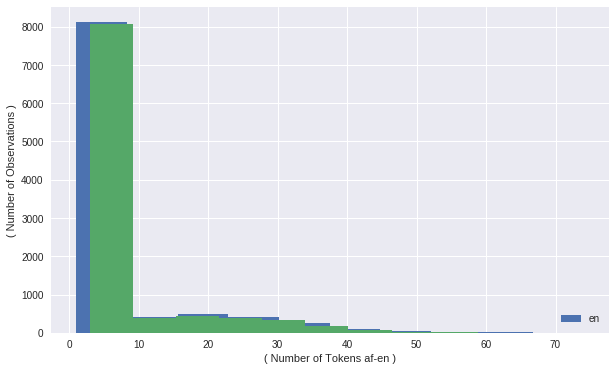

In [13]:
root_plots_dir = "./Loss_Acc_train_plots"
encoder_seq_len = 5
decoder_seq_len = 5
gru_units = 10    # Number of GRU units
n_epochs, batch_size = 1, 4
if __name__ == '__main__':
            # This code won't run if this file is imported.
            #initialize object
            data_wrapper = Data_Wrapper_MT("./MT-datasets", "./Monolinguals", "./M2M-CL-Embeddings", "./Bilexicons_Folder", "./EDA_Destination_Folder")
            inference_wrapper = Inference("./Saved_X_lingual_MT_Models", "./Saved_lang_Tokenizers", "./Test_Translation_Documents", "Loss_Acc_Document")
            list_langs = ['af', 'xho', 'zul', 'ssw', 'nr', 'nso', 'st', 'tsn', 'ven', 'tso', 'en']
            results_pairs = [(i, j) for i in list_langs for j in list_langs if i != j]
            for pair in results_pairs:
                         if pair[0] == "en" and pair[1] == "xho" :
                                    # load datasets
                                    source_d_text, target_d_text, src_bilex_text, trg_bilex_text = data_wrapper.load_source_target(pair[0], pair[1])
                                    # Basic EDA plots source and target bar
                                    eda_plots = data_wrapper.plot_seq_length(pd.Series(source_d_text + src_bilex_text), pd.Series(target_d_text + trg_bilex_text), pair)
                                    # Basic EDA kind box
                                    # eda_plots_2 = data_wrapper.plot_seq_length(pd.Series(source_d_text + src_bilex_text), pd.Series(target_d_text + trg_bilex_text), pair, kind="box")
                                    # leartn tokenizers
                                    src_data_tokenizer, trg_data_tokenizer = data_wrapper.encode_decode_tokenizers(source_d_text + src_bilex_text,  target_d_text + trg_bilex_text )
                                    
                                    # initialize cross embeddings layers
                                    print("Initializing embeddings layer")
                                    src_emb_layer, trg_emb_layer = data_wrapper.load_embeddings(pair[0], pair[1], src_data_tokenizer, trg_data_tokenizer, True)
                                    
                                    # train_test_split
                                    """
                                    split data into train, dev and test with test = 20 %, and train = 80 % from test split. Therefore dev = 20 % of train split
                                    """
                                    src_train_dev_test_split, trg_train_dev_test_split = data_wrapper.train_test_split(80, 80, source_d_text, target_d_text, src_bilex_text, trg_bilex_text)
                                    print(f"The sizes of source language {pair[0]} and target language {pair[1]} --> train {len(src_train_dev_test_split[0])}, dev {len(src_train_dev_test_split[1])}, and test {len(src_train_dev_test_split[2])}")
                                    # print(f"The size of target language {pair[1]} --> train {len(trg_train_dev_test_split[0])}, dev {len(trg_train_dev_test_split[1])}, and test {len(trg_train_dev_test_split[2])}")
 

                                    #initialize model object Model + "_" + pair[0] + "_" pair[1] 
                                    Model_src_trg_obj = Model_Wrapper(encoder_seq_len, decoder_seq_len, len(src_data_tokenizer.word_index) + 1 , len(trg_data_tokenizer.word_index) + 1 ,gru_units, gru_units)
                                    nmt = Model_src_trg_obj.Encoder_Decoder(src_emb_layer, trg_emb_layer)
                                    
                                    
                                    # Old Training and validation
                                    history = nmt.fit(data_wrapper.generate_batch(src_train_dev_test_split[0], trg_train_dev_test_split[0], src_data_tokenizer, trg_data_tokenizer, len(src_data_tokenizer.word_index) + 1 , len(trg_data_tokenizer.word_index) + 1 , batch_size=batch_size),
                                                      steps_per_epoch = len(src_train_dev_test_split[0])//batch_size,
                                                      epochs = n_epochs,
                                                      validation_data = data_wrapper.generate_batch(src_train_dev_test_split[1], trg_train_dev_test_split[1], src_data_tokenizer, trg_data_tokenizer,len(src_data_tokenizer.word_index) + 1 , len(trg_data_tokenizer.word_index) + 1 , batch_size=batch_size),
                                                      validation_steps = len(src_train_dev_test_split[1])//batch_size)

                                    
                                    plot_history(history,root_plots_dir, pair[0], pair[1])
                                    plot_history(history, metric="accuracy")

                                    # save the model
                                    

                                    # Evaluating on completely unseen data
                                    X_test, y_test     =  data_wrapper.feature_extraction(src_train_dev_test_split[2], trg_train_dev_test_split[2], src_data_tokenizer, trg_data_tokenizer,len(src_data_tokenizer.word_index) + 1 , len(trg_data_tokenizer.word_index) + 1 , batch_size=batch_size)

                                    
                                    results = nmt.evaluate([X_test[0], X_test[1]], y_test, steps=batch_size)
                                    print(f"========== Test set loss: {results[0]} - Test set Accuracy: {results[1]*100} % ==========")
                                    
                                    """
                                    TODO - Richard 
                                    check every line below this comment and edit where necessary. 
                                    """
                                    
                                    # Get Model Weights encoder
                                    attention_en_wei = nmt.layers[4].get_weights()
                                    gru_en_weights   = nmt.layers[6].get_weights()
                                    
                                    
                                    # redefine models
                                    # The Envoder definition
                                    en_inputs = Input(shape= (encoder_seq_len,))
                                    src_embeddings  =  src_emb_layer(en_inputs)
                                    src_attention  = Attention(use_scale=False)([src_embeddings, src_embeddings])
                                    src_gru = GRU(gru_units, return_sequences=True, return_state=True)
                                    src_out, src_state = src_gru(src_attention)
                                    encoder = Model(inputs=en_inputs, outputs=en_state)
                                    
                                    # set weights
                                    src_attention.set_weights(attention_en_wei)
                                    src_gru.set_weights(gru_en_weights)
                                    
                                    # get decoder weights
                                    attention_de_wei = nmt.layers[5].get_weights()
                                    gru_de_weights   = nmt.layers[7].get_weights()
                                    dense_de_wei     = nmt.layers[8].get_weights()
                                    
                                    # The decoder definition
                                    de_inputs = Input(shape= (decoder_seq_len,))
                                    trg_embeddings  =  trg_emb_layer(de_inputs)
                                    trg_attention  = Attention(use_scale=False)([trg_embeddings, trg_embeddings])
                                    trg_gru         =  GRU(gru_units, return_sequences=True, return_state=True)
                                    trg_out, trg_state = en_gru(trg_attention)
                                    de_dense = Dense(trg_vocab_size, activation='softmax') 
                                    de_pred = de_dense(de_out)
                                    decoder = Model(inputs=[de_inputs, de_state_in], outputs=[de_pred, trg_state])
                                    
                                    # set weights
                                    trg_attention.set_weights(attention_de_wei)
                                    trg_gru.set_weights(gru_de_weights)
                                    de_dense.set_weights(dense_de_wei)
                                    
                                    # use model to translate
                                    src_trg_collection = []
                                    for src_sentence in X_test[0][len(X_test) - 25:]:
                                                 src_trg_pairs = []
                                                 trg_translation = inference_wrapper.translate(data_wrapper, encoder, decoder, src_sentence, src_tokenizer, trg_tokenizer, src_vocab_size, trg_vocab_size, trg_seq_len)
                                                 src_trg_pairs.append(src_sentence)
                                                 src_trg_pairs.append(trg_translation)
                                                 src_trg_collection.append(src_trg_pairs)
                                                
                                    # save to folder
                                    inference_wrapper.create_translation_doc(src_trg_collection, pair[0], pair[1])
                                    inference_wrapper.add_translation_results(pair[0], pair[1], results[0], results[1])
                                    
                                    # save encoder decoder
                                    inference_wrapper.save_models(ecoder,decoder, pair[0], pair[1])
                                    
                                    # save tokenizers
                                    inference_wrapper.save_tokenizers(src_data_tokenizer, trg_data_tokenizer, pair[0], pair[1])
                                    

# Toy examples to get layers

In [19]:
# src_embedding_sequences = Embedding(13367, 200, embeddings_initializer="uniform")
# trg_embedding_sequences = Embedding(11417, 200, embeddings_initializer="uniform")

In [22]:
# # self.trg_seq_len 
# src_inputs = Input(shape = (20,)) # [None, 20]
# src_embedding = src_embedding_sequences(src_inputs)
# src_attention_layer = Attention(use_scale=False)([src_embedding, src_embedding])
# src_gru = GRU(5, return_sequences=True, return_state=True)
# src_out, src_state = src_gru(src_attention_layer)

# # Decoder
# # self.trg_seq_len - 1
# trg_inputs = Input(shape=(20,))
# trg_embedding = trg_embedding_sequences(trg_inputs)
# trg_attention_layer = Attention(use_scale=False)([trg_embedding, trg_embedding])
# trg_gru = GRU(5, return_sequences=True, return_state=True)
# trg_out, hidden_d = trg_gru(trg_attention_layer, initial_state = src_state)
# trg_dense = TimeDistributed(Dense(11417, activation='softmax'))    
# trg_pred = trg_dense(trg_out)

# # model compiling
# nmt = Model(inputs=[src_inputs, trg_inputs], outputs = trg_pred) 
# nmt.compile(optimizer='adam', loss="categorical_crossentropy", metrics=["acc"])

In [23]:
# nmt.layers

In [ ]:
# data_wrapper = Data_Wrapper_MT("../../MT-datasets/", "../../Monolinguals", "../../Cross-lingula", "../../Bilexicons_Folder/")

In [ ]:
# source_d, target_d, src_b, trg_b = data_wrapper.load_source_target("af", "en")

In [ ]:
# s_prep, t_prep = data_wrapper.train_test_split(80, 80, source_d, target_d, src_b, trg_b)

In [ ]:
# print(f"The size of source train {len(s_prep[0])}, dev {len(s_prep[1])}, and test {len(s_prep[2])}")

In [60]:
import numpy as np
vocab_train = 13367
vocab_label = 11417
embedding_dim = 200
units = 32
n_sample = 10
seq_length = 20
X_enc = np.random.randint(0,vocab_train, (n_sample,20))
X_dec = np.random.randint(0,vocab_label, (n_sample,seq_length))
y = np.random.randint(0, 2, (n_sample,seq_length,vocab_label))

In [66]:
X_dec[0]

array([2454,  922, 4843, 7103, 1914, 8181, 1738, 9627, 3445, 7502, 9823,
        937, 2052, 3801, 5009, 5072, 2419, 9986, 2625, 3463])

In [5]:
src_embedding_sequences = Embedding(13367, 200, embeddings_initializer="uniform")
trg_embedding_sequences = Embedding(11417, 200, embeddings_initializer="uniform")

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [62]:
# self.trg_seq_len 
src_inputs = Input(shape = (20,)) # [None, 20]
src_embedding = src_embedding_sequences(src_inputs)
# src_attention_layer = Attention(use_scale=False)([src_embedding, src_embedding])
src_attention_layer, attn_weights = CustomAttention()(src_embedding)
src_gru = GRU(5, return_sequences=True, return_state=True)
src_out, src_state = src_gru(src_attention_layer)

# Decoder
# self.trg_seq_len - 1
trg_inputs = Input(shape=(20,))
trg_embedding = trg_embedding_sequences(trg_inputs)
trg_attention_layer = Attention(use_scale=False)([trg_embedding, trg_embedding])
trg_gru = GRU(5, return_sequences=True, return_state=True)
trg_out, hidden_d = trg_gru(trg_attention_layer, initial_state = src_state)
trg_dense = TimeDistributed(Dense(11417, activation='softmax'))    
trg_pred = trg_dense(trg_out)

# model compiling
nmt = Model(inputs=[src_inputs, trg_inputs], outputs = trg_pred) 
nmt.compile(optimizer='adam', loss="categorical_crossentropy", metrics=["acc"])

In [58]:
nmt.summary()

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_17 (InputLayer)           [(None, 20)]         0                                            
__________________________________________________________________________________________________
input_18 (InputLayer)           [(None, 20)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           multiple             2673400     input_17[0][0]                   
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 20, 200)      2283400     input_18[0][0]                   
____________________________________________________________________________________________

In [61]:
nmt.fit([X_enc, X_dec], y, epochs=3)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 10 samples
Epoch 1/3
10/10 [==============================] - 1s 52ms/sample - loss: 53362.7188 - acc: 0.0000e+00
Epoch 2/3
10/10 [==============================] - 0s 5ms/sample - loss: 53362.3789 - acc: 0.0000e+00
Epoch 3/3
10/10 [==============================] - 0s 5ms/sample - loss: 53362.0195 - acc: 0.0000e+00


In [73]:
we = nmt.layers[4].get_weights()
nmt.layers[4].set_weights(we)

# Get layers

In [12]:
nmt.layers[4] # attention 1
nmt.layers[6] # gru 1
nmt.layers[5] # attention 2
nmt.layers[7] # gru 2
nmt.layers[8] # distributed

In [15]:
attention_en_wei = nmt.layers[4].get_weights()

In [16]:
attention_en_wei

[]

In [17]:
gru_en_weights   = nmt.layers[6].get_weights()

In [19]:
# gru_en_weights

In [48]:
# Get Model Weights encoder
attention_en_wei = nmt.layers[4].get_weights()
gru_en_weights   = nmt.layers[6].get_weights()


# redefine models
# The Encoder definition
en_inputs = Input(shape= (1,))
src_embeddings  =  src_embedding_sequences(en_inputs)
# src_attention  = Attention(use_scale=False)
src_attention  = Attention(use_scale=False)([src_embeddings, src_embeddings])
src_gru = GRU(5, return_sequences=True, return_state=True)
src_out, src_state = src_gru(src_attention)
encoder = Model(inputs=en_inputs, outputs=src_state)
src_gru.set_weights(gru_en_weights)
encoder.summary()

Model: "model_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_23 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           multiple             2673400     input_23[0][0]                   
__________________________________________________________________________________________________
attention_14 (Attention)        (None, 1, 200)       0           embedding[6][0]                  
                                                                 embedding[6][0]                  
__________________________________________________________________________________________________
gru_13 (GRU)                    [(None, 1, 5), (None 3090        attention_14[0][0]        

In [86]:
attention_de_wei = nmt.layers[5].get_weights()
gru_de_weights   = nmt.layers[7].get_weights()
dense_de_wei     = nmt.layers[8].get_weights()

# The decoder definition
de_inputs = Input(shape= (11417,))
de_state_in = Input(shape= (5,))
trg_embeddings  =  trg_embedding_sequences(de_inputs)
# trg_attention  = Attention(use_scale=False)
trg_attention  = Attention(use_scale=False)([trg_embeddings, trg_embeddings])
trg_gru         =  GRU(5, return_sequences=True, return_state=True)
trg_out, trg_state = trg_gru(trg_attention)
de_dense = Dense(vocab_label , activation='softmax') 
de_pred = de_dense(trg_out)
decoder = Model(inputs=[de_inputs, de_state_in], outputs=[de_pred, trg_state])
trg_gru.set_weights(gru_de_weights)
de_dense.set_weights(dense_de_wei)
decoder.summary()

Model: "model_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_23 (InputLayer)           [(None, 11417)]      0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         multiple             2283400     input_23[0][0]                   
__________________________________________________________________________________________________
attention_10 (Attention)        (None, 11417, 200)   0           embedding_1[4][0]                
                                                                 embedding_1[4][0]                
__________________________________________________________________________________________________
gru_17 (GRU)                    [(None, 11417, 5), ( 3090        attention_10[0][0]        

In [91]:
decoder.layers[5]

In [120]:
def word_to_onehot(word, vocab_size):
    
    """ Converts a single word into onehot representation.
    
    Args:
        tokenizer (tf.keras.preprocessing.text.Tokenizer): Tensorflow tokenizer object.
        word (str): Word to be tokenized and onehot encoded.
        vocab_size (int): Number of words in the whole vocabulary.
    
    Returns:
        de_onhot (list): Onehot representation of given word.
        
    """
    
    de_seq = np.array([1010])
    de_onehot = to_categorical(de_seq, num_classes=vocab_size).reshape( 1, vocab_size)  
    
    return de_onehot

In [121]:
X_dec[0]


array([10860,  7946,  1590,  8705, 10317,  7425,  9808,  3605,  2060,
        2173,  5110,  9221,   191, 11266,  6587, 10092,  9569,  7266,
         912,  4628])

In [122]:
w = word_to_onehot("word", 11417)

In [123]:
w

array([[0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [50]:
y[0].shape

(20, 11417)

In [93]:
en_seq = X_enc[0]
en_st = encoder.predict(np.array(en_seq))
# en_st[0]
# de_seq = word_to_onehot(it_tok, "sos", it_vocab_size)
de_seq = w
# it_sent = ""
# # for i in range(it_seq_len):         
de_prob, en_st = decoder.predict([de_seq, en_st])
index = np.argmax(de_prob[0, :], axis=-1)
#     de_w = it_tok.index_word[index]
#     de_seq = word_to_onehot(it_tok, de_w, it_vocab_size) 
#     if de_w == 'eos': break
#     it_sent += de_w + ' '

NameError: name 'w' is not defined

In [110]:
index[0]

11112

In [100]:
index[11112]

11112

In [ ]:
# Get Model Weights encoder
attention_en_wei = nmt.layers[4].get_weights()
gru_en_weights   = nmt.layers[6].get_weights()


# redefine models
# The Encoder definition
en_inputs = Input(shape= (seq_length,))
src_embeddings  =  src_emb_layer(en_inputs)
# src_attention  = Attention(use_scale=False)
src_attention  = Attention(use_scale=False)([src_embeddings, src_embeddings])
src_gru = GRU(gru_units, return_sequences=True, return_state=True)
src_out, src_state = src_gru(src_attention)
encoder = Model(inputs=en_inputs, outputs=src_state)

# set weights
# src_attention.set_weights(attention_en_wei)
# src_attention_output = src_attention([src_embeddings, src_embeddings])
# src_gru = GRU(gru_units, return_sequences=True, return_state=True)
# src_out, src_state = src_gru(src_attention_output)
# encoder = Model(inputs=en_inputs, outputs=src_state)
src_gru.set_weights(gru_en_weights)
print(encoder.summary())
# get decoder weights
attention_de_wei = nmt.layers[5].get_weights()
gru_de_weights   = nmt.layers[7].get_weights()
dense_de_wei     = nmt.layers[8].get_weights()

# The decoder definition
de_inputs = Input(shape= (decoder_seq_len,))
de_state_in = Input(shape= (gru_units,))
trg_embeddings  =  trg_emb_layer(de_inputs)
# trg_attention  = Attention(use_scale=False)
trg_attention  = Attention(use_scale=False)([trg_embeddings, trg_embeddings])
trg_gru         =  GRU(gru_units, return_sequences=True, return_state=True)
trg_out, trg_state = trg_gru(trg_attention)
de_dense = Dense(len(trg_data_tokenizer.word_index) + 1, activation='softmax') 
de_pred = de_dense(trg_out)
decoder = Model(inputs=[de_inputs, de_state_in], outputs=[de_pred, trg_state])

In [2]:
class Model_Wrapper:
    def Encoder_Decoder(self, src_emb_layer, trg_emb_layer):
        # Encoder
        # self.trg_seq_len 
        self.src_inputs = Input(shape = (20,)) # [None, 20]
        self.src_embedding_sequences = src_emb_layer(self.src_inputs) # [None, 20, 200]
        self.src_attention_layer = Attention(use_scale=False)([self.src_embedding_sequences, self.src_embedding_sequences])
        self.src_gru = GRU(5, return_sequences=True, return_state=True)
        self.src_out, self.src_state = self.src_gru(self.src_attention_layer)
        
        
        # Decoder
        # self.trg_seq_len - 1
        self.trg_inputs = Input(shape=(20,))
        self.trg_embedding_sequences = trg_emb_layer(self.trg_inputs)
        self.trg_attention_layer = Attention(use_scale=False)([self.trg_embedding_sequences, self.trg_embedding_sequences])
        self.trg_gru = GRU(5, return_sequences=True, return_state=True)
        self.trg_out, hidden_d = self.trg_gru(self.trg_attention_layer, initial_state = self.src_state)
        self.trg_dense = TimeDistributed(Dense(11418, activation='softmax'))    
        self.trg_pred = self.trg_dense(self.trg_out)
        
        # model compiling
        nmt = Model(inputs=[self.src_inputs, self.trg_inputs], outputs = self.trg_pred) 
        nmt.compile(optimizer='adam', loss="categorical_crossentropy", metrics=["acc"])
        
        print(nmt.summary())
        return nmt

    # return attention src
    def get_Attention_1(self,):
            return self.src_attention_layer
    
    def get_Attention_2(self,):
            return self.trg_attention_layer

In [6]:
obj = Model_Wrapper()

In [7]:
nmt = obj.Encoder_Decoder(src_embedding_sequences, trg_embedding_sequences)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 20)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 20)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 20, 200)      2673400     input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 20, 200)      2283400     input_2[0][0]                    
_____________

In [8]:
att = obj.get_Attention_1()

In [17]:
att

<tf.Tensor 'attention/MatMul_1:0' shape=(?, 20, 200) dtype=float32>

In [78]:
gru_en_weights   = nmt.layers[6].get_weights()


# redefine models
# The Encoder definition
en_inputs = Input(shape= (1,))
src_embeddings  =  src_embedding_sequences(en_inputs)
# src_attention  = Attention(use_scale=False)
# src_attention = Attention(use_scale=False, return_attention_scores=True)([src_embeddings, src_embeddings])
src_attention, attn_weights = CustomAttention()(src_embeddings)
# src_attention = att
src_gru = GRU(5, return_sequences=True, return_state=True)
src_out, src_state = src_gru(src_attention)
encoder = Model(inputs=en_inputs, outputs=src_state)
src_gru.set_weights(gru_en_weights)
encoder.summary()

Model: "model_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_22 (InputLayer)        [(None, 1)]               0         
_________________________________________________________________
embedding (Embedding)        multiple                  2673400   
_________________________________________________________________
custom_attention_9 (CustomAt ((None, 1, 200), (None, 1 120000    
_________________________________________________________________
gru_16 (GRU)                 [(None, 1, 5), (None, 5)] 3090      
Total params: 2,796,490
Trainable params: 2,796,490
Non-trainable params: 0
_________________________________________________________________


In [82]:
encoder.layers[2].get_weights()

[array([[ 0.02739114,  0.05869712,  0.04125505, ..., -0.0414524 ,
         -0.01321885, -0.00778681],
        [ 0.005569  , -0.01787361, -0.00258336, ...,  0.11083088,
         -0.0481852 ,  0.06598014],
        [-0.05304746,  0.0226344 ,  0.01155334, ..., -0.03073661,
         -0.06675497, -0.01322996],
        ...,
        [-0.05502572,  0.03625637, -0.00631793, ..., -0.005086  ,
          0.05157558,  0.03848467],
        [-0.06956178, -0.07117637,  0.08264324, ..., -0.02385855,
         -0.09164532,  0.04490397],
        [-0.01559316, -0.04234954,  0.0796225 , ...,  0.10675714,
         -0.00382941,  0.03039161]], dtype=float32),
 array([[-0.04815827,  0.04404342,  0.04731196, ..., -0.02803381,
          0.04054996,  0.0157356 ],
        [ 0.01667677, -0.1002574 , -0.02866348, ..., -0.00522761,
         -0.03821593, -0.05233166],
        [ 0.00280667, -0.06686115, -0.013961  , ...,  0.009312  ,
         -0.0434284 ,  0.0596703 ],
        ...,
        [ 0.07349294,  0.03683276,  0.0

In [85]:
encoder.layers[3]

In [44]:
atten.trainable_weights

[]

In [28]:
att = obj.get_Attention_2()

In [29]:
att

<tf.Tensor 'attention_9/MatMul_1:0' shape=(?, 20, 200) dtype=float32>

In [31]:
src_attention_layer

<tf.Tensor 'attention_10/MatMul_1:0' shape=(?, 20, 200) dtype=float32>

In [50]:
class CustomAttention(Layer):
    def __init__(self, **kwargs):
        super(CustomAttention, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W_q = self.add_weight(
            shape=(input_shape[-1], input_shape[-1]),
            initializer='random_normal',
            trainable=True,
            name='query_weights'
        )
        self.W_k = self.add_weight(
            shape=(input_shape[-1], input_shape[-1]),
            initializer='random_normal',
            trainable=True,
            name='key_weights'
        )
        self.W_v = self.add_weight(
            shape=(input_shape[-1], input_shape[-1]),
            initializer='random_normal',
            trainable=True,
            name='value_weights'
        )

    def call(self, inputs):
        q = tf.matmul(inputs, self.W_q)
        k = tf.matmul(inputs, self.W_k)
        v = tf.matmul(inputs, self.W_v)

        # Compute attention scores
        attn_scores = tf.matmul(q, k, transpose_b=True)
        attn_scores = tf.nn.softmax(attn_scores, axis=-1)

        # Apply attention scores to values
        output = tf.matmul(attn_scores, v)
        return output, attn_scores